In [1]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import scipy.stats
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from matplotlib import pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def bound_score(score):
    if score > 10:
        return 10
    elif score < 0:
        return 0
    return score

main_df = pd.read_csv('titles.csv', encoding='unicode_escape')
#main_df.head()

In [2]:
credits_df = pd.read_csv('credits.csv')
credits_df.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [3]:
# this block of code generates a dictionary, with keys being the movie id, and values being another dictionary with 2 keys 'actor' and 'director'
credits_dict = dict()
id_prev = ''
for i in range(0,len(credits_df)):
    id_curr = credits_df['id'][i]
    name_curr = credits_df['name'][i]
    role_curr = credits_df['role'][i].lower()
    person_id_curr = credits_df['person_id'][i]
    # this if is needed to initialise a dictionary for each *new* movie id
    if id_curr != id_prev:
        id_prev = id_curr
        credits_dict[id_curr] = {'actor':set(), 'director':set(), 'actor_id':set(), 'director_id':set()}
        credits_dict[id_curr][role_curr].add(name_curr)
        if role_curr == 'actor':
            credits_dict[id_curr]['actor_id'].add(person_id_curr)
        else:
            credits_dict[id_curr]['director_id'].add(person_id_curr)
    else:
        credits_dict[id_curr][role_curr].add(name_curr)
        if role_curr == 'actor':
            credits_dict[id_curr]['actor_id'].add(person_id_curr)
        else:
            credits_dict[id_curr]['director_id'].add(person_id_curr)
#print(credits_dict)

In [4]:
# adding actor and director column to the main_df
main_df['actor'] = ''
main_df['actor_id'] = ''
main_df['director'] = ''
main_df['director_id'] = ''
#print(credits_dict['tm84618']['actor'])
#print(main_df[main_df['id'] == 'tm84618'].index[0])
for id in credits_dict:
    index = main_df[main_df['id'] == id].index[0]
    main_df.at[index, 'actor'] = credits_dict[id]['actor']
    main_df.at[index, 'actor_id'] = credits_dict[id]['actor_id']
    main_df.at[index, 'director'] = credits_dict[id]['director']
    main_df.at[index, 'director_id'] = credits_dict[id]['director_id']
#main_df.head()

# replace all empty cells with the empty list
selected_columns = ['actor', 'actor_id', 'director', 'director_id']
empty_count = 0
for column in selected_columns:
    main_df[column] = main_df[column].apply(lambda x: '{}' if not x else x)

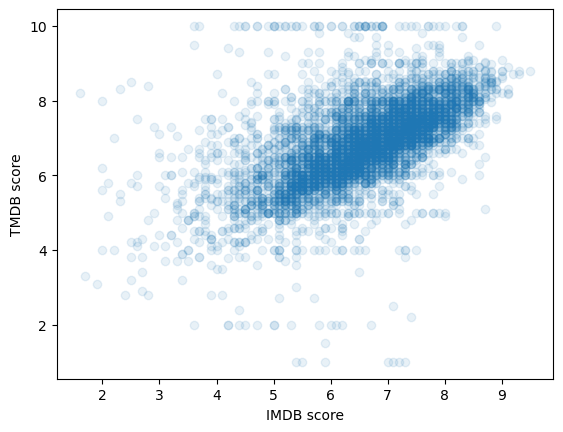

In [5]:
# this block aims to fill in missing data of the imputed_columns.
# rows with no values across all 4 cells will be imputed by column mean
# imdb_score wil be fitted with tmdb_score with a linear model
# imdb_votes vs tmdb_popularity as well

# first, look for relationships between the 2 scores metric
plt.scatter(main_df['imdb_score'], main_df['tmdb_score'], alpha=0.1)
plt.xlabel('IMDB score')
plt.ylabel('TMDB score')
plt.savefig('Figures/imdb_vs_tmdb_score.png')
# good linear fit

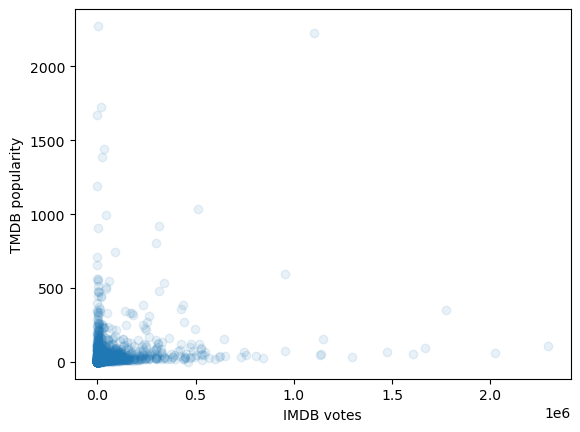

In [6]:
# next, the 2 popularity metrics
plt.scatter(main_df['imdb_votes'], main_df['tmdb_popularity'], alpha=0.1)
plt.xlabel('IMDB votes')
plt.ylabel('TMDB popularity')
plt.savefig('Figures/imdb_vs_tmdb_votes_no_transform.png')
# pretty horrible fit: there are lots of high votes number, and many high popularity number

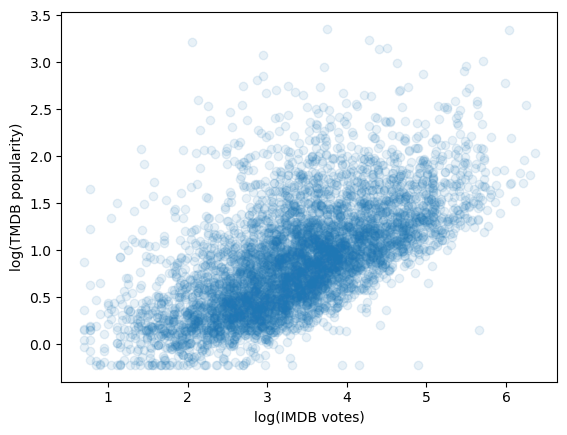

In [7]:
# hence, take the log base 10 of both axes
plt.scatter(main_df['imdb_votes'].apply(lambda x: math.log(x, 10)), main_df['tmdb_popularity'].apply(lambda x: math.log(x, 10)), alpha=0.1)
plt.xlabel('log(IMDB votes)')
plt.ylabel('log(TMDB popularity)')
plt.savefig('Figures/log_imdb_vs_log_tmdb_score.png')
# much better linear fit now: there are still some heteroskedasticity, and the error distribution does not
# look to be normally distributed, but this is good enough

In [8]:
# make the model using entries with both scores value (tmdb = m*imdb + c)
# first, obtain only the known values
model = LinearRegression()
imdb_score_known = []
tmdb_score_known = []
for i in range(0, len(main_df)):
    if (not pd.isna(main_df['imdb_score'][i]) and not pd.isna(main_df['tmdb_score'][i])):
        imdb_score_known.append(main_df['imdb_score'][i])
        tmdb_score_known.append(main_df['tmdb_score'][i])

imdb_df = pd.DataFrame(imdb_score_known, columns=['imdb'])
tmdb_df = pd.DataFrame(tmdb_score_known, columns=['tmdb'])

i_train, i_test, t_train, t_test = train_test_split(imdb_df, tmdb_df, test_size =0.2, random_state=0)

model.fit(i_train, t_train)
t_pred = model.predict(i_train)
print(f'MSE for training data: {mean_squared_error(t_train, t_pred)}')

t_pred = model.predict(i_test)
print(f'MSE for testing data: {mean_squared_error(t_test, t_pred)}')

# get the intercept and the slope
intercept = model.intercept_
slope = model.coef_[0]

# fill in the data
for i in range(0, len(main_df)):
    # if imdb score exists, but not tmdb, use tmdb = m*imdb + c
    if (not pd.isna(main_df['imdb_score'][i]) and pd.isna(main_df['tmdb_score'][i])):
        main_df.at[i, 'tmdb_score']= bound_score(slope*main_df['imdb_score'][i] + intercept)
    # if tmdb exists, but not imdb: imdb = (tmdb - c)/m
    elif (pd.isna(main_df['imdb_score'][i]) and not pd.isna(main_df['tmdb_score'][i])):
        main_df.at[i, 'imdb_score'] = bound_score((main_df['tmdb_score'][i] - intercept)/slope)

MSE for training data: 0.8972640093340225
MSE for testing data: 0.8364494916895118


In [9]:
# now, a model for the log (base 10) of the votes and log of the popularity
# log(popularity) = m*log(votes) + c
model = LinearRegression()
votes_known = []
popularity_known = []
for i in range(0, len(main_df)):
    if (not pd.isna(main_df['imdb_votes'][i]) and not pd.isna(main_df['tmdb_popularity'][i])):
        votes_known.append(math.log(main_df['imdb_votes'][i], 10))
        popularity_known.append(math.log(main_df['tmdb_popularity'][i], 10))

votes_df = pd.DataFrame(votes_known, columns=['votes'])
popularity_df = pd.DataFrame(popularity_known, columns=['popularity'])

v_train, v_test, p_train, p_test = train_test_split(votes_df, popularity_df, test_size =0.2, random_state=0)

model.fit(v_train, p_train)
p_pred = model.predict(v_train)
print(f'MSE for training data: {mean_squared_error(p_train, p_pred)}')

p_pred = model.predict(v_test)
print(f'MSE for testing data: {mean_squared_error(p_test, p_pred)}')

intercept = model.intercept_
slope = model.coef_[0]

# fill in the data
for i in range(0, len(main_df)):
    # if votes exist, use popularity = 10^(m*log(votes) + c)
    if (not pd.isna(main_df['imdb_votes'][i]) and pd.isna(main_df['tmdb_popularity'][i])):
        main_df.at[i, 'tmdb_popularity']= 10**(slope*math.log(main_df['imdb_votes'][i], 10) + intercept)
    # if popularity exist, use votes = 10^((log(popularity) - c)/m)
    # note that i am rounding down every numbers. it doesn't really matter (in this context) ig
    elif (pd.isna(main_df['imdb_votes'][i]) and not pd.isna(main_df['tmdb_popularity'][i])):
        main_df.at[i, 'imdb_votes'] = int(10**((math.log(main_df['tmdb_popularity'][i], 10) - intercept)/slope))


MSE for training data: 0.19486132629558497
MSE for testing data: 0.20510448991940458


/tmp/ipykernel_169/1463139234.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  main_df.at[i, 'imdb_votes'] = int(10**((math.log(main_df['tmdb_popularity'][i], 10) - intercept)/slope))


In [10]:
# lastly, fill in all blank NaN cells with the median
imputed_columns = ['imdb_score','imdb_votes','tmdb_popularity','tmdb_score']
main_df[imputed_columns] = main_df[imputed_columns].fillna(main_df[imputed_columns].median())

In [11]:
# this block is for natural language processing 
# implement tokenisation for every descriptions, with punctuation and stopwords removed
main_df['tokens'] = ''
stop_words = set(stopwords.words('english'))
porterStemmer = PorterStemmer()
printable = set(string.printable)
def desc_to_stemmed_tokens(desc, stop_words, stemmer):
    # filter out non ascii characters
    filter(lambda x: x in printable, desc)
    desc = desc.lower()
    # filter out all punctuation (except apostrophes)
    desc = re.sub(r'[^A-Za-z\s\']', ' ', desc)
    # deleting all apostrophes, making them into one word
    desc = re.sub(r'\'', ' ', desc)
    # delete multiple spaces
    desc = re.sub(r'\s+', ' ', desc) 

    tokens = nltk.word_tokenize(desc)
    tokens = [w for w in tokens if not w in stop_words]
    stemmed = [stemmer.stem(w) for w in tokens]
    cleaned_desc = ' '.join(stemmed)
    return {'cleaned':cleaned_desc, 'tokens':stemmed}

for i in range(0,len(main_df)):
    if(type(main_df['description'][i]) is float):
        main_df.at[i, 'tokens'] = []
    else:
        output = desc_to_stemmed_tokens(main_df['description'][i], stop_words, porterStemmer)
        main_df.at[i, 'tokens'] = output['tokens']
        main_df.at[i, 'description'] = output['cleaned']

In [12]:
# rearrange columns, also removing data that will not be considered in this research
cols = ['id','title', 'description', 'tokens', 'runtime', 'genres', 'production_countries','imdb_id', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score', 'actor', 'actor_id', 'director', 'director_id']
main_df = main_df[cols]
main_df.head()

,id,title,description,tokens,runtime,genres,production_countries,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,actor,actor_id,director,director_id
0,ts300399,Five Came Back: The Reference Films,collect includ world war ii era propaganda fil...,"[collect, includ, world, war, ii, era, propaga...",51,['documentation'],['US'],NaN,6.6,2.0,0.600,6.900,{},{},{},{}
1,tm84618,Taxi Driver,mental unstabl vietnam war veteran work night ...,"[mental, unstabl, vietnam, war, veteran, work,...",114,"['drama', 'crime']",['US'],tt0075314,8.2,808582.0,40.965,8.179,"{Peter Boyle, Cybill Shepherd, Debbi Morgan, S...","{32267, 29068, 466061, 17421, 43791, 43279, 43...",{Martin Scorsese},{3308}
2,tm154986,Deliverance,intent see cahulawasse river turn one huge lak...,"[intent, see, cahulawasse, river, turn, one, h...",109,"['drama', 'action', 'thriller', 'european']",['US'],tt0068473,7.7,107673.0,10.010,7.300,"{Herbert 'Cowboy' Coward, James Dickey, Billy ...","{197405, 100262, 53804, 24509, 24510, 84031, 8...",{John Boorman},{17727}
3,tm127384,Monty Python and the Holy Grail,king arthur accompani squir recruit knight rou...,"[king, arthur, accompani, squir, recruit, knig...",91,"['fantasy', 'action', 'comedy']",['GB'],tt0071853,8.2,534486.0,15.461,7.811,"{Scott Mike, William Palin, Mary Allen, Avril ...","{8327, 1275018, 1549, 919694, 90024, 156072, 4...","{Terry Jones, Terry Gilliam}","{11473, 11475}"
4,tm120801,The Dirty Dozen,american militari prison world war ii order in...,"[american, militari, prison, world, war, ii, o...",150,"['war', 'action']","['GB', 'US']",tt0061578,7.7,72662.0,20.398,7.600,"{Leo Britt, Tom Busby, Trini López, Warren Sta...","{35200, 35201, 35202, 35203, 35204, 21244, 352...",{Robert Aldrich},{1063}


In [13]:
# export data out for other programs to unicode_escape
main_df.to_csv('titles_mod2.csv', index=False)